## Advanced image classification using ILWISPy in conjuntion with SciKit 
Notebook prepared by Ben Maathuis and Bas Retsios. ITC-University of Twente, Enschede. The Netherlands

This notebook is a continuation of the initial land cover classification of Sentinel-2 MSI satellite image as conducted in the notebook 'Intro_RS_ILWISPy.ipynb'. Ensure that the Sample data is locally available. It can be retrieved from: https://filetransfer.itc.nl/pub/52n/ilwis_py/sample_data/ILWISPy_ImageClassification.zip. Unzip the file. 

Here it is assumed that the data folder '/ILWISPy_ImageClassification' is situated within the notebook folder! It is furthermore assumed that you have locally installed ILWIS386 for data visualization when data is written to disk and have gone throught the notebook 'Intro_RS_ILWISPy.ipynb'.

Additional image classifiers used within this notebook are:
+ Random Forest
+ K-Nearest Neighbor Classifier(K-NNC)
+ Support Vector Machine (SVM)
+ Gradient Boosting Classifier (LightGBM) 

Prerequisite: You have reviewed the notebook 'Intro_ILWISPy.ipynb' and 'Intro_RS_ILWISPy.ipynb', available at: https://filetransfer.itc.nl/pub/52n/ilwis_py/notebooks/. Note that the files with postfix _result.html files show the processed results if the notebook would be executed.

#### Import Modules

In [1]:
import os
import ilwis
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import lightgbm as lgb
import pandas as pd

In [2]:
#use the Python function os.getcwd() to retrieve the current folder used and add a sub-folder containing the sample data
work_dir = os.getcwd() + '/ILWISPy_ImageClassification'

#set the working directory for ILWISPy
ilwis.setWorkingCatalog(work_dir)
print(work_dir)
ilwis.version()

/home/ilwispy/notebooks/ilwispy_tutorial/ILWISPy_ImageClassification


'1.0 build 20250227'

### Read Data and get meta data information
Two datasets are at your disposal, an ilwis map list containing a sub set of Sentinel 2, as created in the notebook 'Intro_RS_ILWISPy.ipynb' and a map showing the samples which are used for the supervised classification routines used below. 

The data sets have been visualized in the notebook 'Intro_RS_ILWISPy.ipynb' already, if you want to display the image and the sample map, use ILWIS 386. This step is omitted here and the data is directly loaded.

In [3]:
# Load the multi-spectral image 
s2_raster = ilwis.RasterCoverage('s2A_sub.mpl')

#print some metadata
print(s2_raster.size())

Size(2600, 1750, 9)


Convert the map list into Numpy array

In [4]:
rcsat = np.fromiter(iter(s2_raster), np.float64, s2_raster.size().linearSize()) 
rcsat = rcsat.reshape((s2_raster.size().zsize, s2_raster.size().ysize, s2_raster.size().xsize))
rcsat.shape

(9, 1750, 2600)

In [5]:
#reshape the order
x_sat = np.moveaxis(rcsat, 0, -1)
x_sat = x_sat.reshape(rcsat.shape[1], rcsat.shape[2], rcsat.shape[0])
x_sat.shape

(1750, 2600, 9)

### Ground truth
For the area of interest a field survey was conducted at approximately the same time as the image was acquired. The following classes are used:

+ 1: mainly bare
+ 2: swamp - depression with open vegatation cover
+ 3: swamp - covered with dense vegetation
+ 4: urban and infrastructure - including bare areas, e.g. between the houses / dirt roads
+ 5: river - like Blue Nile
+ 6: Open water - ponds and some temporary inundated areas related to irrigation scheduling
+ 7, 8, 9: different agricultural crops. Main crops grown during this season (summer season - mainly rainfed) are cotton, groundnut and sorghum

The field survey was used to prepare a map providing the training data required for supervised classification. This map is using the land cover labels as indicated above, note that the background area has been assigned to '0'

In [6]:
gt_data = ilwis.RasterCoverage('samples.mpr')
print(gt_data.size())

Size(2600, 1750, 1)


Also convert the sample data into Numpy array

In [7]:
y_data = np.fromiter(iter(gt_data), np.ubyte, gt_data.size().linearSize()) 
y_data = y_data.reshape((gt_data.size().ysize, gt_data.size().xsize))
y_data.shape

(1750, 2600)

#### Pairing Y with X
Now that we have the image we want to classify (our X feature inputs), and the Training Data with the land cover labels (our Y labeled data), we need to pair them in NumPy arrays so we may feed them to our classifier.

Reshape our training input data

In [8]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (y_data > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(y_data[y_data > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))


X = x_sat[y_data > 0] 
y = y_data[y_data > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 67062 samples
The training data include 9 classes: [1 2 3 4 5 6 7 8 9]
Our X matrix is sized: (67062, 9)
Our y array is sized: (67062,)


### Train Test Split
Now we split the sample data into a training and testing data set, 70 % is used for training and the remaining data for testing the classifier.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (46943, 9) (46943,)
Test set: (20119, 9) (20119,)


#### The Random Forest classifier
#### Training the Random Forest
Now that we have our X matrix of feature inputs (the spectral bands) and our y array (the labels), we can train our model. 

In [10]:
# initialize our model with 500 trees
# calculate the out of bag score
# use multi core processing
rf = RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=-1)

# Fit our model to training data
rf = rf.fit(X_train, y_train)

Random Forest diagnostics:
With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

In [11]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 96.50427113733677%


To help us get an idea of which spectral bands were important, we can look at the feature importance scores:

In [12]:
bands = [1, 2, 3, 4, 5, 6, 7, 8, 9]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.06413157400068413
Band 2 importance: 0.06884924643225447
Band 3 importance: 0.1230359783605062
Band 4 importance: 0.09315527695839475
Band 5 importance: 0.08799390897544786
Band 6 importance: 0.11794443696803959
Band 7 importance: 0.10093230979943885
Band 8 importance: 0.1629194944964851
Band 9 importance: 0.18103777400874901


Review the weights assigned for each of the spectral channels used, those with the largest weights look the most useful to use.

Let's look at a cross-tabulation to see the class confusion. To do so, we will use the Pandas library

In [13]:
df_train = pd.DataFrame()
df_train['truth'] = y_train
df_train['predict'] = rf.predict(X_train)

# Show cross-tabulate predictions
print(pd.crosstab(df_train['truth'], df_train['predict'], margins=True))

predict     1     2    3     4     5    6     7     8     9    All
truth                                                             
1        7872     0    0     0     0    0     0     0     0   7872
2           0  6912    0     0     0    0     0     0     0   6912
3           0     0  526     0     0    0     0     0     0    526
4           0     0    0  9698     0    0     0     0     0   9698
5           0     0    0     0  2635    0     0     0     0   2635
6           0     0    0     0     0  636     0     0     0    636
7           0     0    0     0     0    0  7885     0     0   7885
8           0     0    0     0     0    0     0  4876     0   4876
9           0     0    0     0     0    0     0     0  5903   5903
All      7872  6912  526  9698  2635  636  7885  4876  5903  46943


It will be very doubtfull if the real confusion matrix will be having a 100% accuracy. What is likely going on is that we used a large number of trees within a machine learning algorithm to best figure out the pattern in our training data. Given enough information and effort, this algorithm precisely learned what we gave it. Asking to validate a machine learning algorithm on the training data is a useless exercise that will overinflate the accuracy.

Instead, we use the test data to get a better indication of the accuracy.

In [14]:
df_test = pd.DataFrame()
df_test['truth'] = y_test
df_test['predict'] = rf.predict(X_test)

# Show cross-tabulate predictions
print(pd.crosstab(df_test['truth'], df_test['predict'], margins=True))

predict     1     2    3     4     5    6     7     8     9    All
truth                                                             
1        3361     0    0    32     0    0     6    21     5   3425
2           2  2899   11     2     0    0     1    14     1   2930
3           0    39  199     0     0    0     0     0     0    238
4          42     0    0  4177     0    0     5     2     0   4226
5           0     0    0     0  1123    0     0     0     0   1123
6           0     1    0     0     0  278     0     0     0    279
7          26     0    0    11     0    0  3355    14     3   3409
8          75     5    0     2     0    0    20  1777   158   2037
9          19     1    1     1     0    0    22   177  2231   2452
All      3525  2945  211  4225  1123  278  3409  2005  2398  20119


In [15]:
rf_pred = rf.predict(X_test)

In [16]:
print(f"Accuracy: {accuracy_score(y_test, rf_pred)*100}")

Accuracy: 96.42626373080174


In [17]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           1       0.95      0.98      0.97      3425
           2       0.98      0.99      0.99      2930
           3       0.94      0.84      0.89       238
           4       0.99      0.99      0.99      4226
           5       1.00      1.00      1.00      1123
           6       1.00      1.00      1.00       279
           7       0.98      0.98      0.98      3409
           8       0.89      0.87      0.88      2037
           9       0.93      0.91      0.92      2452

    accuracy                           0.96     20119
   macro avg       0.96      0.95      0.96     20119
weighted avg       0.96      0.96      0.96     20119



The meaning of precision, recall, F-measure and support for each class:

+ The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

+ The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

+ The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

+ The support is the number of occurrences of each class in y_true.

#### Classifying the image stack using the RF classifier
Predicting the rest of the image. Continue with the Random Forest classifier as trained above and proceed to classify the entire image . To reshape the image take the full image and reshape into long 2d array (nrow * ncol, nband) for classification

In [18]:
# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (x_sat.shape[0] * x_sat.shape[1], x_sat.shape[2])

img_as_array = x_sat[:, :, :9].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o = x_sat.shape, n = img_as_array.shape))

# Now predict for each pixel
rf_class = rf.predict(img_as_array)

# Reshape our classification map
rf_class = rf_class.reshape(x_sat[:, :, 0].shape)
rf_class.shape

Reshaped from (1750, 2600, 9) to (4550000, 9)


(1750, 2600)

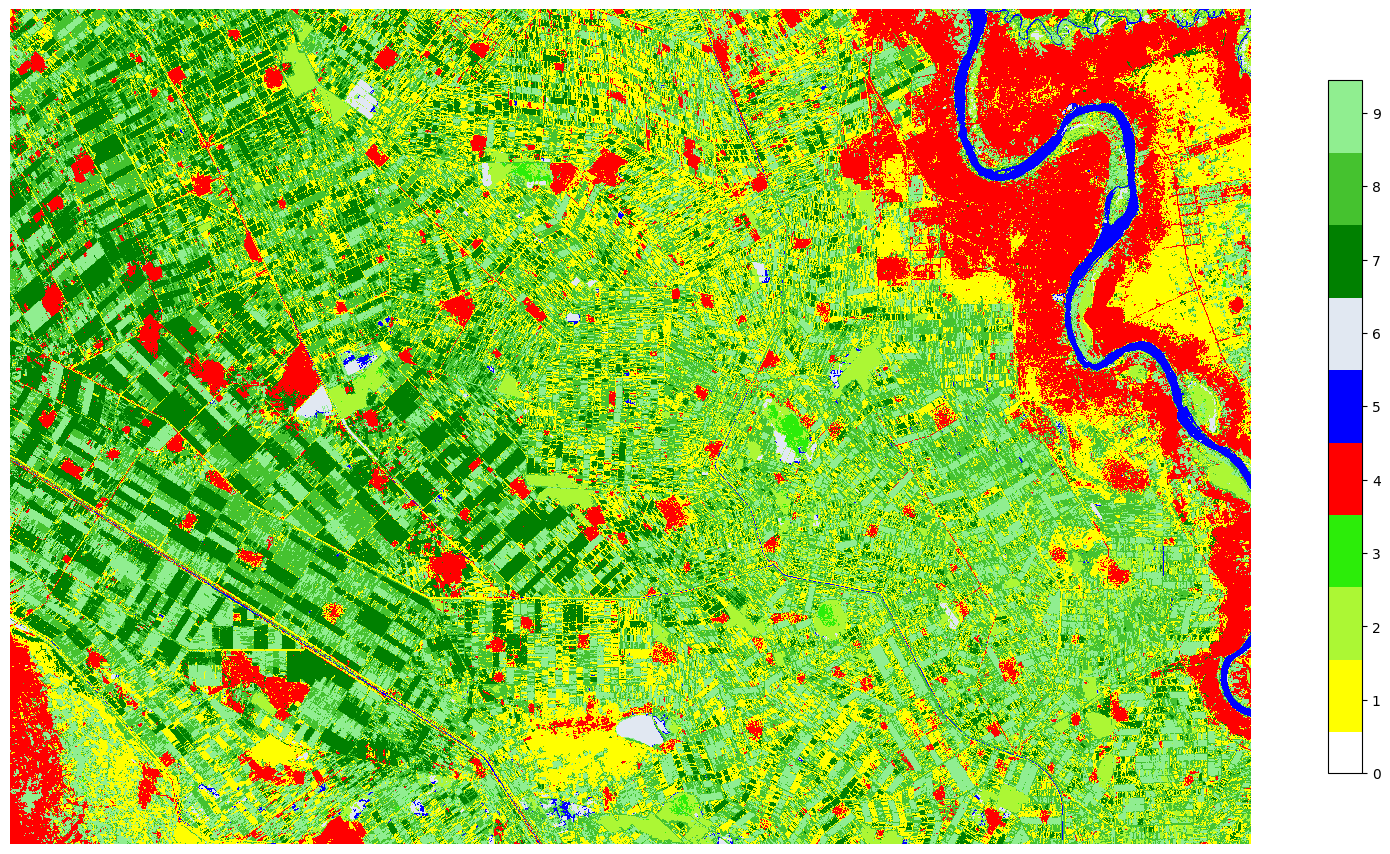

In [19]:
fig = plt.figure(figsize = (20, 20))
plt.imshow(rf_class, interpolation='none', cmap=ListedColormap(['yellow','#acf734', '#2ced09', 'red', 'blue', '#e1e8f2', 'green',  '#45c22f', 'lightgreen']))
loc = np.arange(0.5,9.5,0.9)
labels = np.arange(0,10,1)
cb = plt.colorbar(shrink=0.45)
cb.set_ticks(loc)
cb.set_ticklabels(labels)
plt.axis('off')
plt.show()

###  Scaling

Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation. Scaling is done to Normalize data so that priority is not given to a particular feature. Role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance. Random Forest, as applied above, is a tree-based model and hence does not require feature scaling.

Reshape input satellite spectral channels

In [20]:
x = np.moveaxis(rcsat, 0, -1)
x.shape

(1750, 2600, 9)

Scale the input satellite spectral channels

In [21]:
X_data = x.reshape(-1, 9)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(4550000, 9)

In [22]:
X_scaled_new = (rcsat.shape[1], rcsat.shape[2], rcsat.shape[0])
X_array = X_scaled.reshape(X_scaled_new)
X_array.shape

(1750, 2600, 9)

In [23]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (y_data > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(y_data[y_data > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))


X1 = X_array[y_data > 0] 
y1 = y_data[y_data > 0]

print('Our X matrix is sized: {sz}'.format(sz=X1.shape))
print('Our y array is sized: {sz}'.format(sz=y1.shape))

We have 67062 samples
The training data include 9 classes: [1 2 3 4 5 6 7 8 9]
Our X matrix is sized: (67062, 9)
Our y array is sized: (67062,)


In [24]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (46943, 9) (46943,)
Test set: (20119, 9) (20119,)


### K-Nearest Neighbor Classifier (K-NNC)
k-Nearest Neighbor Classifier is one of the widely used classifiers in machine learning. The main objective of this method is that the data instances of the same class should be closer in the feature space. K used in KNN classifier represents the number of nearest neighbors to examine. It is supposed to be specified by the User. So, how can we choose right value for K?

In the cell below we calculate the accuracy of KNN for different Ks. 

In [25]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.96302003, 0.95695611, 0.96560465, 0.96227447, 0.9650082 ,
       0.96316914, 0.96401412, 0.96167802, 0.96232417])

Plot model accuracy for different number of Neighbors

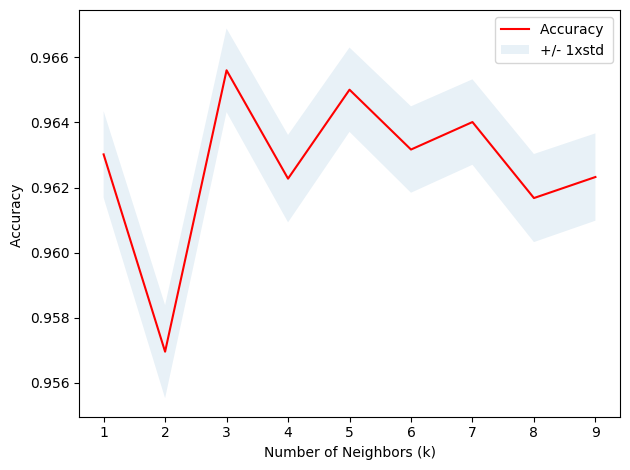

In [26]:
plt.plot(range(1,Ks),mean_acc,'r')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 1xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (k)')
plt.tight_layout()
plt.show()

In [27]:
print( "The best accuracy was with", mean_acc.max()*100, "with k=", mean_acc.argmax()+1) 

The best accuracy was with 96.56046523187037 with k= 3


The cells below K-NNC instance with n_neighbors has to be specified (note k = 3 was providing the highest accuracy) and fits the train data, predicts the labels of the test data, shows the accuracy, and prints the classification report which includes precision, recall and F1-score of each class. 

In [28]:
k = 3 #number of neighbours defined having highest accuracy

knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1) # n_jobs set so it supports multi core processing
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

Accuracy classification score.

In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

In [29]:
print(f"Accuracy: {accuracy_score(y_test, knn_pred)*100}")

Accuracy: 96.56046523187037


In [30]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           1       0.95      0.99      0.97      3425
           2       0.98      0.99      0.99      2930
           3       0.90      0.82      0.86       238
           4       0.99      0.99      0.99      4226
           5       1.00      1.00      1.00      1123
           6       1.00      1.00      1.00       279
           7       0.99      0.99      0.99      3409
           8       0.88      0.88      0.88      2037
           9       0.94      0.91      0.92      2452

    accuracy                           0.97     20119
   macro avg       0.96      0.95      0.96     20119
weighted avg       0.97      0.97      0.97     20119



In [31]:
# Classification using K-NNC
knn_class = knn.predict(X_scaled).reshape(1750,2600)
knn_class.shape

(1750, 2600)

<Figure size 640x480 with 0 Axes>

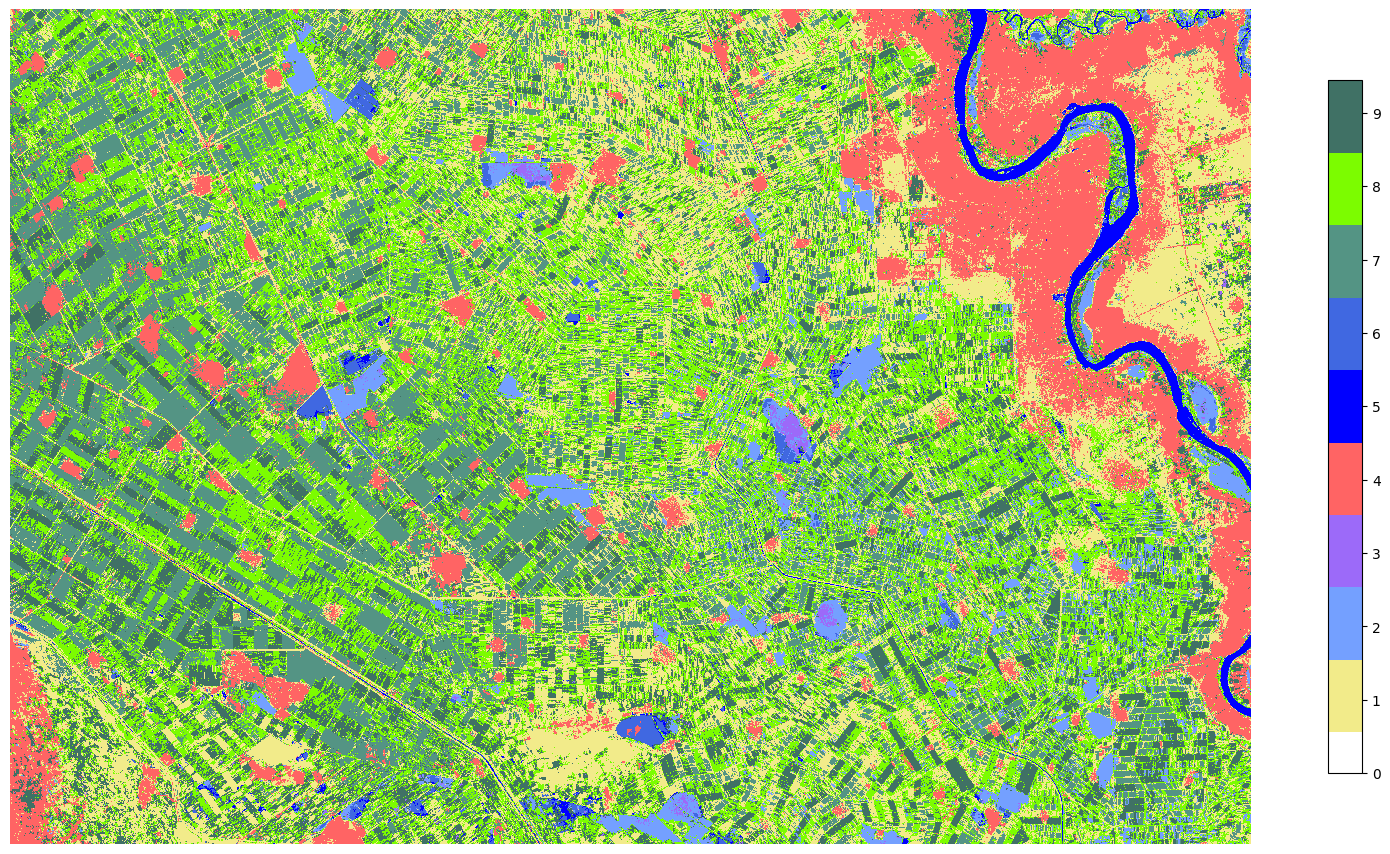

In [32]:
# Plot of classfied K-NNC map
plt.figure()
fig = plt.figure(figsize = (20, 20))
plt.imshow(knn_class, interpolation='none', cmap=ListedColormap(['#F2EB8A', '#74A0FF', '#9C6AF9', '#FF6464', '#0000FF', '#4068E1', '#549484', '#7CFC00', '#407165']))
cb = plt.colorbar(shrink=0.45)
loc = np.arange(0.5,9.5,0.9)
labels = np.arange(0,10,1)
cb.set_ticks(loc)
cb.set_ticklabels(labels)
plt.axis('off')
plt.show()

### Support Vector Machine (SVM)

The support vector machine (SVM) is a supervised learning method that generates input-output mapping functions from a set of labeled training data. The mapping function can be either a classification function, i.e., the category of the input data, or a regression function.

For classification, nonlinear kernel functions such as Radial Basis Function (RBF), Polynomial, Sigmoid, etc. are often used to transform input data to a high-dimensional feature space in which the input data become more separable compared to the original input space. Maximum-margin hyperplanes are then created. The model thus produced depends on only a subset of the training data near the class boundaries.

The below code is used to create an instance of SVM with the regularization parameter C as 3 and linear kernel. Fits the data, predict the labels for test data, and prints the accuracy and classification report.

In [33]:
from sklearn.svm import SVC

svm = SVC(C=3.0, kernel='linear', degree=6, cache_size=1024)
svm.fit(X_train, y_train)

SVC(C=3.0, cache_size=1024, degree=6, kernel='linear')

In [34]:
svm_pred = svm.predict(X_test)

In [35]:
print(f"Accuracy: {accuracy_score(y_test, svm_pred)*100}")

Accuracy: 95.31288831452855


In [36]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           1       0.93      0.97      0.95      3425
           2       0.98      0.99      0.98      2930
           3       0.95      0.77      0.85       238
           4       0.99      0.98      0.98      4226
           5       1.00      1.00      1.00      1123
           6       1.00      1.00      1.00       279
           7       0.97      0.98      0.98      3409
           8       0.85      0.83      0.84      2037
           9       0.92      0.90      0.91      2452

    accuracy                           0.95     20119
   macro avg       0.95      0.94      0.94     20119
weighted avg       0.95      0.95      0.95     20119



In [37]:
# Visualize Classification Map of SVM
svm_class = svm.predict(X_scaled).reshape(1750, 2600)

<Figure size 640x480 with 0 Axes>

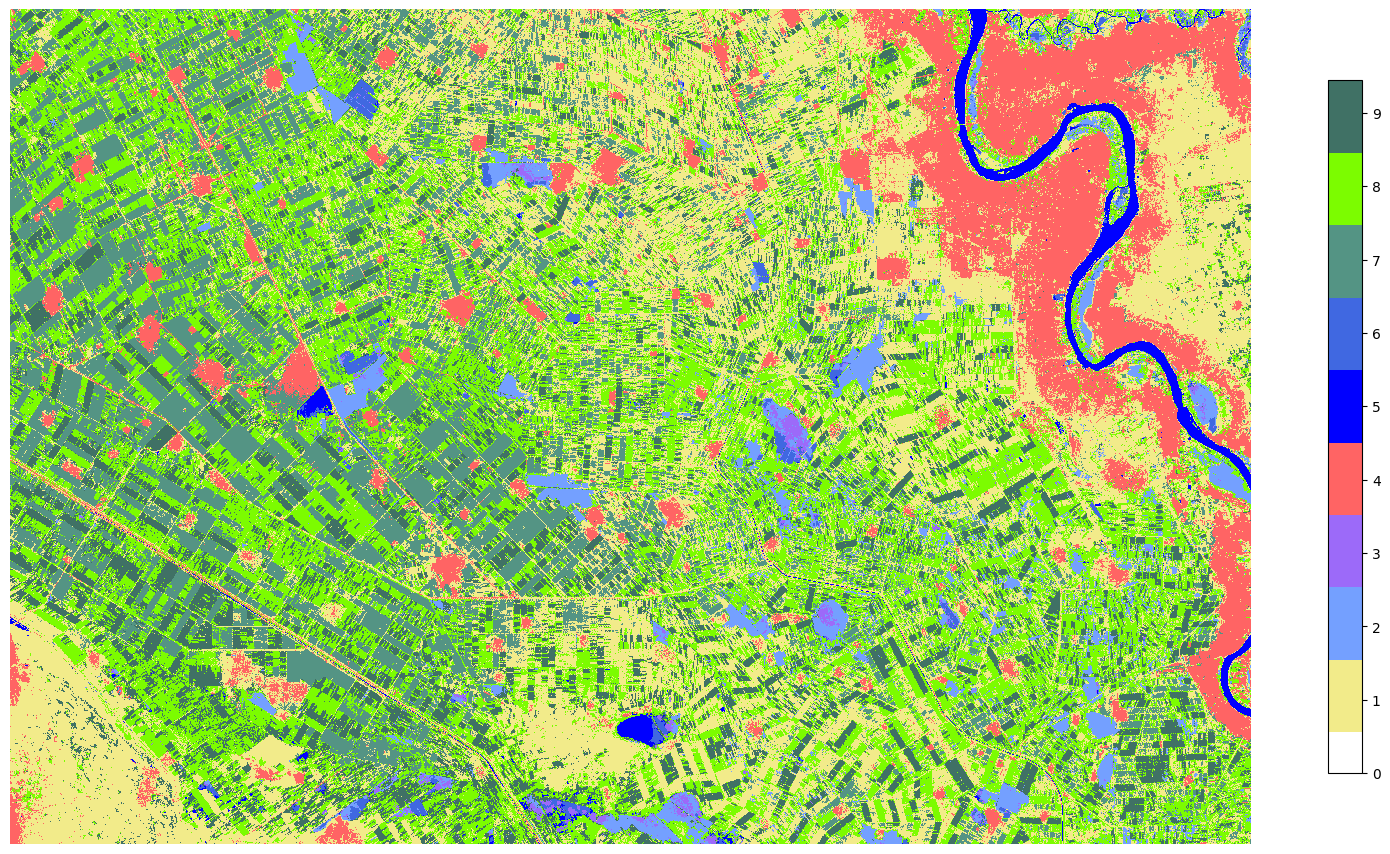

In [38]:
# Plot of classfied SVM map
plt.figure()
fig = plt.figure(figsize = (20, 20))
plt.imshow(svm_class, interpolation='none', cmap=ListedColormap(['#F2EB8A', '#74A0FF', '#9C6AF9', '#FF6464', '#0000FF', '#4068E1', '#549484', '#7CFC00', '#407165']))
cb = plt.colorbar(shrink=0.45)
loc = np.arange(0.5,9.5,0.9)
labels = np.arange(0,10,1)
cb.set_ticks(loc)
cb.set_ticklabels(labels)
plt.axis('off')
plt.show()

### Light Gradient Boosting Classifier (GBM)
Gradient boosting is a technique attracting attention for its prediction speed and accuracy, especially with large and complex data. Gradient boosting is a type of machine learning boosting. It relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error. The key idea is to set the target outcomes for this next model to minimize the error.

Today we are going to use lightGBM which is a gradient boosting framework that makes use of tree-based learning algorithms. LightGBM is called “Light” because of its computation power and giving results faster. It takes less memory to run and can deal with large amounts of data. It is one of the most widely used algorithms in competition because the motive of the algorithm is to get good accuracy of results.

The below code is used to create an instance of the lightgbm with parameters such as learning rate, maximum depth, number of classes, etc.

In [39]:
d_train = lgb.Dataset(X_train, label=y_train)

params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=20
params['num_leaves']=11
params['num_class']=11 #no.of unique values in the target class not inclusive of the end value

clf = lgb.train(params, d_train, 100)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 46943, number of used features: 9
[LightGBM] [Info] Start training from score -34,538776
[LightGBM] [Info] Start training from score -1,785622
[LightGBM] [Info] Start training from score -1,915675
[LightGBM] [Info] Start training from score -4,491388
[LightGBM] [Info] Start training from score -1,577014
[LightGBM] [Info] Start training from score -2,880051
[LightGBM] [Info] Start training from score -4,301491
[LightGBM] [Info] Start training from score -1,783972
[LightGBM] [Info] Start training from score -2,264609
[LightGBM] [Info] Start training from score -2,073473
[LightGBM] [Info] Start training from score -34,538776


In [40]:
lgb_predictions = clf.predict(X_test)

In [41]:
print(lgb_predictions[1], np.argmax(lgb_predictions[1]))

[4.53103852e-16 7.03841949e-03 5.76394779e-03 7.76375444e-04
 6.47154721e-03 1.57906327e-03 3.98287592e-04 5.29266485e-03
 3.72742754e-01 5.99936940e-01 4.53103852e-16] 9


In [42]:
lgb_pred = np.argmax(lgb_predictions, axis=1)
lgb_pred.shape

(20119,)

In [43]:
print(f"Accuracy: {accuracy_score(y_test, lgb_pred)*100}")

Accuracy: 94.5971469754958


In [44]:
print(classification_report(y_test, lgb_pred))

              precision    recall  f1-score   support

           1       0.91      0.96      0.94      3425
           2       0.98      0.98      0.98      2930
           3       0.94      0.80      0.86       238
           4       0.99      0.98      0.98      4226
           5       1.00      1.00      1.00      1123
           6       1.00      1.00      1.00       279
           7       0.97      0.98      0.98      3409
           8       0.84      0.79      0.81      2037
           9       0.90      0.88      0.89      2452

    accuracy                           0.95     20119
   macro avg       0.95      0.93      0.94     20119
weighted avg       0.95      0.95      0.95     20119



In [45]:
#  Classification using LightGBM
gbm_class = np.argmax(clf.predict(X_scaled), axis=1).reshape((1750, 2600))

<Figure size 640x480 with 0 Axes>

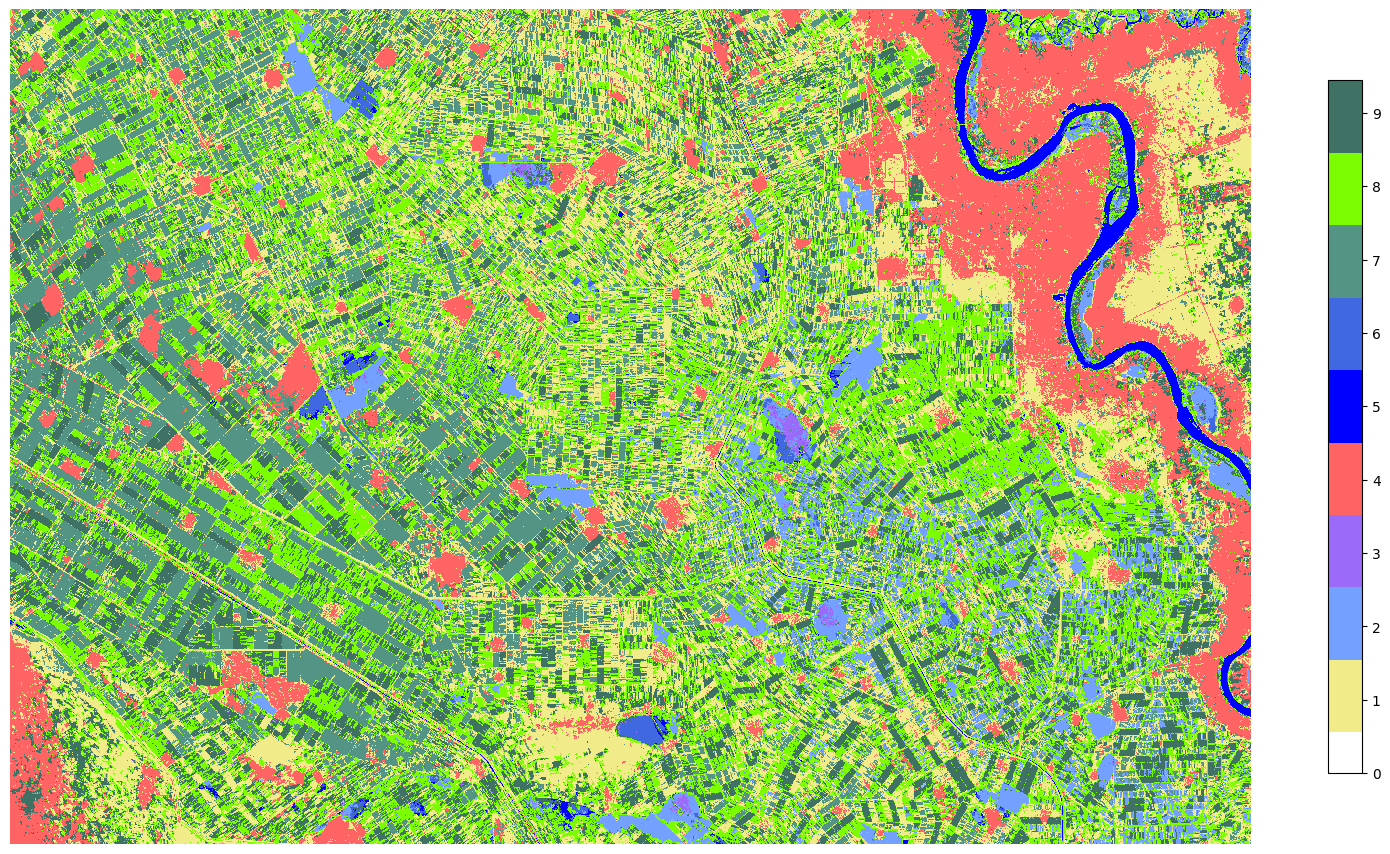

In [46]:
# Plot of classfied LightGBM map
plt.figure()
fig = plt.figure(figsize = (20, 20))
plt.imshow(gbm_class, interpolation='none', cmap=ListedColormap(['#F2EB8A', '#74A0FF', '#9C6AF9', '#FF6464', '#0000FF', '#4068E1', '#549484', '#7CFC00', '#407165']))
cb = plt.colorbar(shrink=0.45)
loc = np.arange(0.5,9.5,0.9)
labels = np.arange(0,10,1)
cb.set_ticks(loc)
cb.set_ticklabels(labels)
plt.axis('off')
plt.show()

Save the classfied images with into ILWIS format, examples below for the fr, knn, svm and gmb accordingly. First a new -empty Raster Coverage is created which is filled with the classified data arrays using the function 'array2raster()'

In [47]:
# envelope =  min X, max Y, max X, min Y,  here 499980 1600020 609780 1490220 (metric units - meters)
# gridsize =  no columns, no rows
# note name of georeference - here the name of output file created further below is used

grf = ilwis.GeoReference('code=georef:type=corners, csy=epsg:29636, envelope=514780 1599920 566780 1564920, gridsize=2600 1750, cornerofcorners=yes, name=class')
dfNum = ilwis.DataDefinition(ilwis.NumericDomain('code=value'), ilwis.NumericRange(0, 10, 1)) 
rcNew = ilwis.RasterCoverage()
rcNew.setSize(ilwis.Size(2600, 1750))
rcNew.setGeoReference(grf)
rcNew.setDataDef(dfNum)

Write the individual classified results into output maps, check the initial data type and transform to same output format data type

In [48]:
rcrf = rcNew
print(rf_class.dtype)
rcrf.array2raster(rf_class.astype(np.uint8)) 
print(rcrf.size())
rcrf.store('rf_cl.mpr')
print(rf_class.dtype)

uint8
Size(2600, 1750, 1)
uint8


In [49]:
rcknn = rcNew
print(knn_class.dtype)
rcknn.array2raster(knn_class.astype(np.uint8)) 
print(rcknn.size())
rcknn.store('knn_cl.mpr')
print(knn_class.dtype)

uint8
Size(2600, 1750, 1)
uint8


In [50]:
rcsvm = rcNew
print(svm_class.dtype)
rcsvm.array2raster(svm_class.astype(np.uint8)) 
print(rcsvm.size())
rcsvm.store('svm_cl.mpr')
print(svm_class.dtype)

uint8
Size(2600, 1750, 1)
uint8


In [51]:
rcgbm = rcNew
print(gbm_class.dtype)
rcgbm.array2raster(gbm_class.astype(np.uint8)) 
print(rcgbm.size())
rcgbm.store('gbm_cl.mpr')
print(gbm_class.dtype)

int64
Size(2600, 1750, 1)
int64


Note that for the 'gbm_class' some further data type manipulation is required as it is in a dtype 'int64' and the other 3 layers are in dtype uint8

In [52]:
#transform to dtype uint8
gbm_classuint8 = np.uint8(gbm_class)
print(gbm_classuint8.dtype)

uint8


#### Evaluation of your results
Have the different classifiers applied using the same input multi spectral image as well as the same sample data set performed in a similar manner, or are the results obtained different? From the images displayed above it is hard to draw conclusions.  So therefor some simple additional analysis is conducted. 

In [53]:
# create stack
cl_stack = np.array([rf_class, knn_class, svm_class, gbm_classuint8])

print(cl_stack.shape)
print(cl_stack.dtype)

(4, 1750, 2600)
uint8


Transform the stack of classified images into ILWIS

In [54]:
# envelope =  min X, max Y, max X, min Y,  here 499980 1600020 609780 1490220 (metric units - meters)
# gridsize =  no columns, no rows
# note name of georeference - here the name of output file created further below is used

grf = ilwis.GeoReference('code=georef:type=corners, csy=epsg:29636, envelope=514780 1599920 566780 1564920, gridsize=2600 1750, cornerofcorners=yes, name=class')
dfNum = ilwis.DataDefinition(ilwis.NumericDomain('code=value'), ilwis.NumericRange(0, 10, 1)) 
rcout = ilwis.RasterCoverage()
rcout.setSize(ilwis.Size(2600, 1750, 4))
rcout.setGeoReference(grf)
rcout.setDataDef(dfNum)

In [55]:
rcout.array2raster(cl_stack) 
print(rcout.size())

Size(2600, 1750, 4)


Eventually store the output map stack and display it using ILWIS 386, uncomment the line in the cell below

In [56]:
#rcout.store('cl_stack.mpl')

Conduct some further statistical analysis

In [57]:
ilwis.operationMetaData('aggregaterasterstatistics')

'aggregaterasterstatistics(inputraster,statisticalmarker=mean|variance|standarddev|totalsumsquares|skew|kurtosis|max|min|maxindex|minindex|median|sum)'

In [58]:
# calculate median and standard deviation for the classified image stack
rc_median = ilwis.do('aggregaterasterstatistics', rcout, 'median')
rc_std = ilwis.do('aggregaterasterstatistics', rcout, 'standarddev')

If you want to store your results uncomment the lines in the cell below and open the maps in ILWIS 386

In [59]:
#rc_median.store('cl_median.mpr')
#rc_std.store('cl_std.mpr')

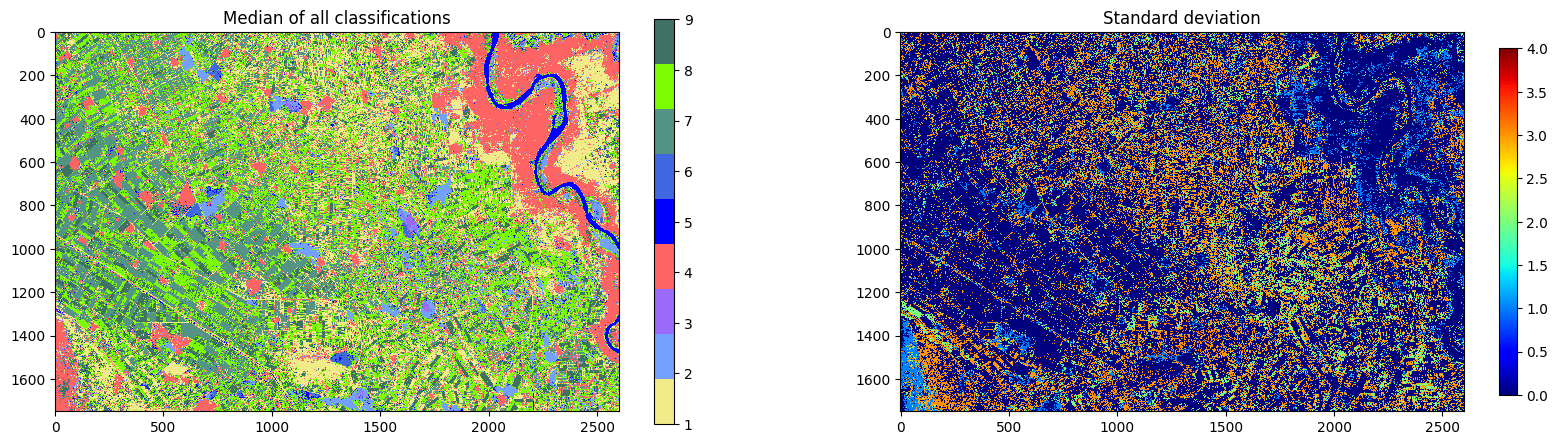

In [60]:
# create a plot of the numpy arrays using MatPlotLib - Imshow
# using the Median and standard deviation
median_2np = np.fromiter(iter(rc_median), np.uint8, rc_median.size().linearSize()) 
median_2np = median_2np.reshape((rc_median.size().ysize, rc_median.size().xsize))

std_2np = np.fromiter(iter(rc_std), np.uint8, rc_std.size().linearSize()) 
std_2np = std_2np.reshape((rc_std.size().ysize, rc_std.size().xsize))

fig1 = plt.figure(figsize=(20, 15))
plt.subplot(1, 2, 1)
plt.imshow(median_2np, interpolation='none', cmap=ListedColormap(['#F2EB8A', '#74A0FF', '#9C6AF9', '#FF6464', '#0000FF', '#4068E1', '#549484', '#7CFC00', '#407165']))
plt.title('Median of all classifications')
loc = np.arange(0.5,9.5,0.9)
labels = np.arange(0,10,1)
cb.set_ticks(loc)
cb.set_ticklabels(labels)
plt.axis('on')
plt.colorbar(shrink=0.35)

plt.subplot(1, 2, 2)
plt.imshow(std_2np, interpolation = 'none', cmap = 'jet')
plt.title('Standard deviation')
plt.axis('on')
plt.colorbar(shrink=0.3)

####  Final comment:
This notebook shows you how to interchange between various sitepackages and make use of the various processing routines offered. You have used four classification routines and lateron selected the median of the classification results obtained as well as standard deviation, showing the uncertainty / differences between the individual classified maps.
    